In [233]:


c4 = 261.626
d4 = 293.665
e4 = 329.629
f4 = 349.228
g4 = 391.995
g3 = 195.998
standard_freqs = [e4,e4,f4,g4,
        g4,f4,e4,d4,
        c4,c4,d4,e4,
        e4,d4,d4,
        e4,e4,f4,g4,
        g4,f4,e4,d4,
        c4,c4,d4,e4,
        d4,c4,c4,
        d4,d4,e4,c4,
        d4,e4,f4,e4,c4,
        d4,e4,f4,e4,d4,
        c4,d4,g3,
        e4,e4,f4,g4,
        g4,f4,e4,d4,
        c4,c4,d4,e4,
        d4,c4,c4]

beat_index = [0,1,2,3,
            4,5,6,7,
            8,9,10,11,
            12,13.5,14,
            16,17,18,19,
            20,21,22,23,
            24,25,26,27,
            28,29.5,30,
            32,33,34,35,
            36,37,37.5,38,39,
            40,41,41.5,42,43,
            44,45,46,
            48,49,50,51,
            52,53,54,55,
            56,57,58,59,
            60,61.5,62]

note_duration = [1, 1, 1, 1,
                1, 1, 1, 1,
                1, 1, 1, 1,
                1.5, 0.5, 2,
                1, 1, 1, 1,
                1, 1, 1, 1,
                1, 1, 1, 1,
                1.5, 0.5, 2,
                1, 1, 1, 1,
                1, 0.5, 0.5, 1, 1,
                1, 0.5, 0.5, 1, 1,
                1, 1, 2,
                1, 1, 1, 1,
                1, 1, 1, 1,
                1, 1, 1, 1,
                1.5, 0.5, 2]

notes = ["E4","E4","F4","G4",
       "G4","F4","E4","D4",
       "C4","C4","D4","E4",
       "E4","D4","D4",
       "E4","E4","F4","G4",
       "G4","F4","E4","D4",
       "C4","C4","D4","E4",
       "D4","C4","C4",
       "D4","D4","E4","C4",
       "D4","E4","F4","E4","C4",
       "D4","E4","F4","E4","D4",
       "C4","D4","G3",
       "E4","E4","F4","G4",
       "G4","F4","E4","D4",
       "C4","C4","D4","E4",
       "D4","C4","C4"]

In [234]:
import array
import numpy as np
import scipy
from pydub.utils import get_array_type
from scipy.fft import fft
import sys
#sys.path.append("/usr/local/lib/python3.7/site-packages")
sys.path.append("/usr/local/lib/python3.8/site-packages")
import essentia
# import essentia.standard as es
from essentia.standard import *
from pydub import AudioSegment

def convert_song_to_array(file_name, segment_ms):
    song = AudioSegment.from_file(file_name)
    print("song length", len(song))
    # Size of segments to break song into for volume calculations
    # SEGMENT_MS = 1
    # dBFS is decibels relative to the maximum possible loudness
    volume = [segment.dBFS for segment in song[::segment_ms]]
    print("volume length",len(volume))
    return song, volume

def detect_bpm(file_name):
    features, features_frames = MusicExtractor(lowlevelStats=['mean', 'stdev'],
                                               rhythmStats=['mean', 'stdev'],
                                               tonalStats=['mean', 'stdev'])(file_name)
    print("BPM from algorithm: ", features['rhythm.bpm'])
    detected_bpm = features['rhythm.bpm']
    return detected_bpm

def detect_onsets(file_name):
    # Loading audio file
    audio = MonoLoader(filename=file_name, sampleRate=44100)()
    # Computing onset detection functions.
    od1 = OnsetDetection(method='hfc')

    w = Windowing(type = 'hann')
    fft = FFT() # this gives us a complex FFT
    c2p = CartesianToPolar() # and this turns it into a pair (magnitude, phase)
    pool = essentia.Pool()

    for frame in FrameGenerator(audio, frameSize = 1024, hopSize = 512):
        mag, phase, = c2p(fft(w(frame)))
        pool.add('features.hfc', od1(mag, phase))

    # compute the actual onsets locations
    onsets = Onsets()

    onsets_hfc = onsets(essentia.array([ pool['features.hfc'] ]), [ 1 ])
    print("number of onsets:", len(onsets_hfc))
    if len(onsets_hfc) > 0:
        print("first onsets: ", onsets_hfc[0])
    else:
        print("no onset")
        
    print(onsets_hfc)
    print(len(onsets_hfc))

    return audio, onsets_hfc

def filter_noise(volume, onsets_hfc, i_range, lowest_volume):
    detected_onsets = []
    for s in onsets_hfc:
        s_i = int(s*1000)
        if (volume[s_i] > lowest_volume or
                volume[s_i+i_range]>lowest_volume or
                volume[s_i-i_range]>lowest_volume):
            detected_onsets.append(s*1000)
        else:
            print("deleted onset at: ", s*1000)

    # print(filter_time)
    # print(len(filter_time))
    # print(t_onsets)
    return detected_onsets

def frequency_spectrum(sample, max_frequency=4187):
    # For single note, the highest note frequency = 4186.009 (for 88 keys piano)
    """
    Derive frequency spectrum of a signal pydub.AudioSample
    Returns an array of frequencies and an array of how prevelant that frequency is in the sample
    """
    # Convert pydub.AudioSample to raw audio data
    # Copied from Jiaaro's answer on https://stackoverflow.com/questions/32373996/pydub-raw-audio-data
    bit_depth = sample.sample_width * 8
    array_type = get_array_type(bit_depth)
    raw_audio_data = array.array(array_type, sample._data)
    n = len(raw_audio_data)

    # Compute FFT and frequency value for each index in FFT array
    # Inspired by Reveille's answer on https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
    freq_array = np.arange(n) * (float(sample.frame_rate) / n)  # two sides frequency range
    freq_array = freq_array[: (n // 2)]  # one side frequency range

    raw_audio_data = raw_audio_data - np.average(raw_audio_data)  # zero-centering
    freq_magnitude = fft(raw_audio_data)  # fft computing and normalization
    freq_magnitude = freq_magnitude[: (n // 2)]  # one side

    if max_frequency:
        max_index = int(max_frequency * n / sample.frame_rate) + 1
        freq_array = freq_array[:max_index]
        freq_magnitude = freq_magnitude[:max_index]

    freq_magnitude = abs(freq_magnitude)
    freq_magnitude = freq_magnitude / np.sum(freq_magnitude)

    return freq_array, freq_magnitude

def detect_frequency(song, detected_onsets, detect_onset_before, detect_onset_after):
    detected_freqs = []
    count = 0
    for start in detected_onsets:
        sample_from = int(start)
        if count < len(note_duration):
            aa = get_bt_ms()*note_duration[count]
        else:
            aa = 125
        sample_to = int(start + aa )
        segment = song[sample_from:sample_to]
        freqs, freq_magnitudes = frequency_spectrum(segment)
        #     print(freqs[np.argmax(freq_magnitudes)])
        lala = freqs[np.argpartition(freq_magnitudes, -10)[-10:]]
#         print(lala)
        sett = True
        
        if count < len(note_duration):
            for la in lala:
                if abs(la - note_duration[count]) < 10:
                    detected_freqs.append(la)
                    sett = False
                    break
        if sett:
            detected_freqs.append(freqs[np.argmax(freq_magnitudes)])
        count = count + 1
#         print (count)
#         print(lala)
#         if count < len(standard_freqs):
#             print(standard_freqs[count])
#         print(freqs[np.argmax(freq_magnitudes)])
#         print ('=' *30 )
    return detected_freqs

In [235]:


def print_function_running(msg):
    print("="*10 + " " + msg + " " + "="*10)

def pretty_print_result(song_name, result, total_num):
    pretty_res = ""
    for i in range(0, total_num):
        pretty_res += (notes[i]+":"+result[i]+" | ")
    print(pretty_res)


In [236]:
import numpy as np
import sys
#sys.path.append("/usr/local/lib/python3.7/site-packages")
sys.path.append("/usr/local/lib/python3.8/site-packages")
from pylab import plot, show, figure, imshow
import matplotlib.pyplot as plt

def plt_hfc_onsets(audio, onsets_hfc):
    plt.rcParams['figure.figsize'] = (18, 6) # set plot sizes to something larger than default
    plot(audio)
    for onset in onsets_hfc:
        plt.axvline(x=onset*44100, color='red')
    plt.title("Audio waveform and the estimated onset positions (HFC onset detection function)")
    plt.show()

def plt_onsets_after_breaking(volume, onsets_hfc):
    plt.rcParams['figure.figsize'] = (18, 6) # set plot sizes to something larger than default
    x_axis = np.arange(len(volume))
    plt.plot(x_axis, volume)
    for s in onsets_hfc:
        plt.axvline(x=s*1000, color='r', linewidth=0.5, linestyle="-")
    plt.show()


def plt_standard_detected_onsets_freqs(standard_onsets, detected_onsets, standard_freqs, detected_freqs):
    plt.rcParams['figure.figsize'] = (18, 6) # set plot sizes to something larger than default
#     for x in standard_onsets:
#         l1 = plt.axvline(x=x, color='g', linewidth=0.5, linestyle="-")

#     for x in detected_onsets:
#         l2 = plt.axvline(x=x, color='r', linewidth=0.5, linestyle="-")

    l3 = plt.plot(detected_onsets, detected_freqs, label = 'detected frequency')
    l4 = plt.plot(standard_onsets, standard_freqs, label= 'standard frequency')
    plt.legend(loc='upper left')
    plt.title("Detected and standard frequency contour")
    plt.show()
    plt.show()

In [237]:
import sys
#sys.path.append("/usr/local/lib/python3.7/site-packages")
sys.path.append("/usr/local/lib/python3.8/site-packages")
import essentia
from essentia.standard import *
# from .process_music_methods import *
# from .print_tool import *
# from .compare_methods import get_compare_result, get_overall_result
# from .plt_methods import plt_hfc_onsets, plt_onsets_after_breaking, plt_standard_detected_onsets_freqs


def get_audio_start_time(detected_onsets, i):
    # in ms
    return detected_onsets[i]


def get_bpm():
    return 119


def get_bt_ms():
#     bpm = get_bpm()
    bt = 60 / bpm
    bt_ms = bt * 1000
    return bt_ms


def get_standard_song_info(song_name, audio_start_time):
    total_num = len(notes)
    bt_ms = get_bt_ms()
    standard_onsets = []
    #in ms
    for i in beat_index:
        standard_onsets.append(audio_start_time + i*bt_ms)

    return standard_onsets, standard_freqs, total_num


#file = "../algo_wxm/audio/longwrongE4.m4a"
def process_music(file_name, start_time, bpm, song_name, onset_i):

    print_function_running("converting song to array")
    song, volume = convert_song_to_array(file_name, segment_ms=1)

    print_function_running("detecting onset")
    audio, onsets_hfc = detect_onsets(file_name)
    plt_hfc_onsets(audio ,onsets_hfc)
    plt_onsets_after_breaking(volume, onsets_hfc)

    print_function_running("filtering noise")
    LOWEST_VOLUME = -40
    VOLUME_RANGE = 5
    detected_onsets = filter_noise(volume, onsets_hfc, VOLUME_RANGE, LOWEST_VOLUME)

    print_function_running("checking if onsets exist")
    if len(detected_onsets) <= 2:
        return [], {}

    print_function_running("detecting bpm")
    detected_bpm = detect_bpm(file_name)

    print_function_running("detecting frequency")
    DETECT_ONSET_BEFORE = 0
    DETECT_ONSET_AFTER = 200
    detected_freqs = detect_frequency(song, detected_onsets, DETECT_ONSET_BEFORE, DETECT_ONSET_AFTER)

    '''
    get the input audio start time, and apply to standard onsets
    '''
    audio_start_time = get_audio_start_time(detected_onsets, onset_i)
    standard_onsets, standard_freqs, total_num = get_standard_song_info(song_name, audio_start_time)
    plt_standard_detected_onsets_freqs(standard_onsets, detected_onsets, standard_freqs, detected_freqs)

    print_function_running("comparing")
    #error tolerance of frequency
    freq_error_tol = 5
    #for duplicate onsets, maybe because of onset detect error, permit a small time diff as only one note
    dup_time_tol = 150
    #for beat time error tolerance
    beat_error_tol = 150
    slot_range = get_bt_ms()
    result, correct_count, freq_error_count, beat_error_count = get_compare_result(song_name,
                                 standard_onsets, standard_freqs,
                                 detected_onsets, detected_freqs,
                                 total_num, slot_range,
                                 dup_time_tol, beat_error_tol, freq_error_tol)

    print_function_running("generating overall report")
#     bpm = get_bpm()
    overall_report = get_overall_result(total_num, correct_count, freq_error_count, beat_error_count, bpm, detected_bpm)

    return result, overall_report

In [238]:
# from music.models import Song, Frequency, Standard
# from .print_tool import *
# from music.models import Song, Frequency, Standard
# from .print_tool import *

def get_standard_detect_time_slot(song_name, standard_onsets, total_num, slot_range):
    # total_num = 62
    #this is time slices for splitting notes
    split_time = []
#     note_duration = Standard.objects.get(name=song_name).info["note_duration"]
    split_time.append((standard_onsets[0]- 0.5*slot_range, standard_onsets[0]+0.5*note_duration[0]*slot_range))
    for i in range(1, total_num-1):
        min_time = standard_onsets[i]-0.5*note_duration[i-1]*slot_range
        max_time = standard_onsets[i]+0.5*note_duration[i]*slot_range
        split_time.append((min_time, max_time))
    #change: the last one note duration
    split_time.append((standard_onsets[total_num-1]-0.5*note_duration[total_num-2]*slot_range,
                       standard_onsets[total_num-1]+0.5*note_duration[total_num-1]*slot_range))
    #print(len(split_time))
    return split_time


def get_detected_onset_freq_pair(song_name, standard_onsets, total_num, detected_onsets, detected_freqs, slot_range):
    #each pair is a list of time, a list of freq for examine at a standard onset
    examine_freqs = []
    for i in range(0, total_num):
        examine_freqs.append(([],[]))

    split_time = get_standard_detect_time_slot(song_name, standard_onsets, total_num, slot_range)

    #separate the onsets into their positions
    cur_onset = 0
    for i in range(0, total_num):
        min_time = split_time[i][0]
        max_time = split_time[i][1]
        for j in range(cur_onset, len(detected_onsets)):
            t = detected_onsets[j]
            freq = detected_freqs[j]
            if (t<min_time):#before the first time slice, very beginning, pass
                cur_onset += 1
                continue
            elif (t>max_time):
                if (i==total_num-1):#final time slice, if >max time, pass all remaining onsets
                    break
                else: #normal case, should stop and go to next time slice
                    break
            else: #fall right into the slice
                (examine_freqs[i])[0].append(t)
                (examine_freqs[i])[1].append(freq)
                cur_onset += 1

    return examine_freqs


def get_compare_result(song_name,
                       standard_onsets, standard_freqs,
                       detected_onsets, detected_freqs,
                       total_num, slot_range,
                       dup_time_tol, beat_error_tol, freq_error_tol):
    examine_freqs = get_detected_onset_freq_pair(song_name,standard_onsets, total_num, detected_onsets, detected_freqs, slot_range)
    result = ["False"]*total_num
    correct_count = 0
    freq_error_count = 0
    beat_error_count = 0
    for i in range(0, total_num):
        examine_t = examine_freqs[i][0]
        examine_f = examine_freqs[i][1]
        standard_t = standard_onsets[i]
        standard_f = standard_freqs[i]
        min_freq = standard_f - freq_error_tol
        max_freq = standard_f + freq_error_tol
        min_time = standard_t - beat_error_tol
        max_time = standard_t + beat_error_tol
        detected_num = len(examine_f)
        if detected_num > 1: # play more notes
            max_time_diff = 0
            for n in range(1, detected_num):
                time_diff = examine_t[n]-examine_t[n-1]
                if time_diff>max_time_diff:
                    max_time_diff = time_diff
            if max_time_diff <= dup_time_tol:
                result[i] = "True"
                correct_count += 1
            else:
                result[i] = "Dup"
                beat_error_count += 1
                freq_error_count += 1
        elif detected_num < 1: # miss the note
            result[i] = "Miss"
            beat_error_count += 1
            freq_error_count += 1
        else:#only one note, see freq
            if ((examine_t[0] >= min_time) and (examine_t[0] <= max_time)):#regard as correct beat
                if ((examine_f[0] >= min_freq) and (examine_f[0] <= max_freq)):#correct freq
                    result[i] = "True"
                    correct_count += 1
                else:
                    result[i] = "WrongFreq"
                    freq_error_count += 1
            else:
                result[i] = "WrongBeat"
                beat_error_count += 1

    pretty_print_result(song_name, result, total_num)
    print("correct_count:", correct_count)
    print("freq_error", freq_error_count)
    print("beat_error", beat_error_count)
    return result, correct_count, freq_error_count, beat_error_count

def get_overall_result(total_num, correct_count, freq_error_count, beat_error_count, bpm, detected_bpm):
    #overall report, a dictionary
    overall_report = {}
    #frequency accuracy: percentage
    freq_accuracy = (total_num - freq_error_count)/total_num
    freq_score = int(freq_accuracy*100)
    overall_report["freq_accuracy"] = freq_accuracy
    overall_report["freq_score"] = freq_score
    print("freq_score",freq_score)
    #beat accuracy: percentage, take into account:dup and wrongbeat
    beat_accuracy = (total_num - beat_error_count)/total_num
    beat_score = int(beat_accuracy*100)
    overall_report["beat_accuracy"] = beat_accuracy
    overall_report["beat_score"] = beat_score
    print("beat_score", beat_score)
    #speed:
    speed = detected_bpm
    speed_score = int((1-(abs(bpm - detected_bpm)/bpm))*100)
    overall_report["speed"] = speed
    overall_report["speed_score"] = 1-(abs(bpm - detected_bpm)/bpm)
    print("speed_score", speed_score)
    # correctness: percentage
    correctness = correct_count/total_num
    correctness_score = int(correctness*100)
    overall_report["correctness"] = correctness
    overall_report["correctness_score"] = correctness_score
    print("correctness_score", correctness_score)

    return overall_report

========== converting song to array ==========
song length 35243
volume length 35243
========== detecting onset ==========
number of onsets: 72
first onsets:  0.12770975
[ 0.12770975  1.4280272   1.9156463   2.4148753   2.9024944   3.4017234
  3.8893423   4.3885713   4.8994102   5.410249    5.9094787   6.4203176
  6.9311566   7.4303856   8.254694    8.498504    9.427301    9.926531
 10.448979   10.936599   11.459047   11.958277   12.457505   12.945125
 13.467574   14.001633   14.500862   15.023311   15.53415    16.288797
 16.544218   17.496235   18.007074   18.471474   18.970703   19.481543
 19.957552   20.23619    20.49161    21.002449   21.490068   22.012518
 22.291157   22.534966   23.080635   23.579865   24.113922   24.613152
 25.58839    26.08762    26.575237   27.086077   27.492426   27.585306
 28.084536   28.583765   29.071383   29.605442   30.104671   30.59229
 30.99864    31.091518   31.567528   32.368618   32.612427   33.692154
 33.843082   34.075283   34.214603   34.353924  

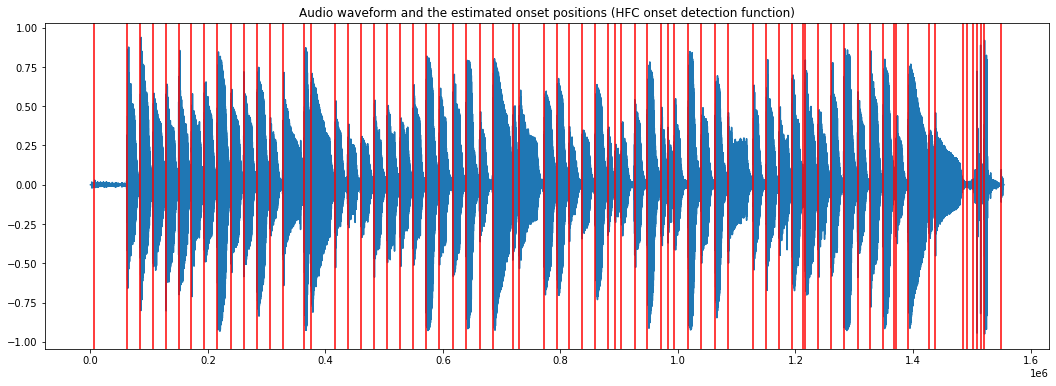

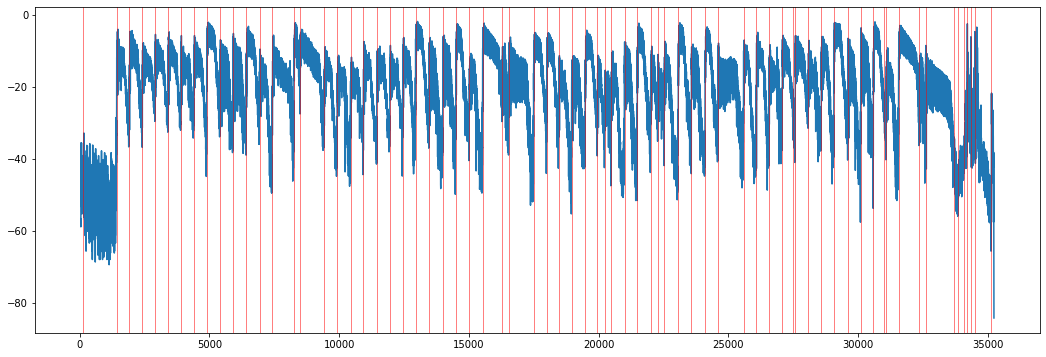

========== filtering noise ==========
deleted onset at:  127.70974636077881
deleted onset at:  33843.082427978516
========== checking if onsets exist ==========
========== detecting bpm ==========
BPM from algorithm:  118.42735290527344
========== detecting frequency ==========


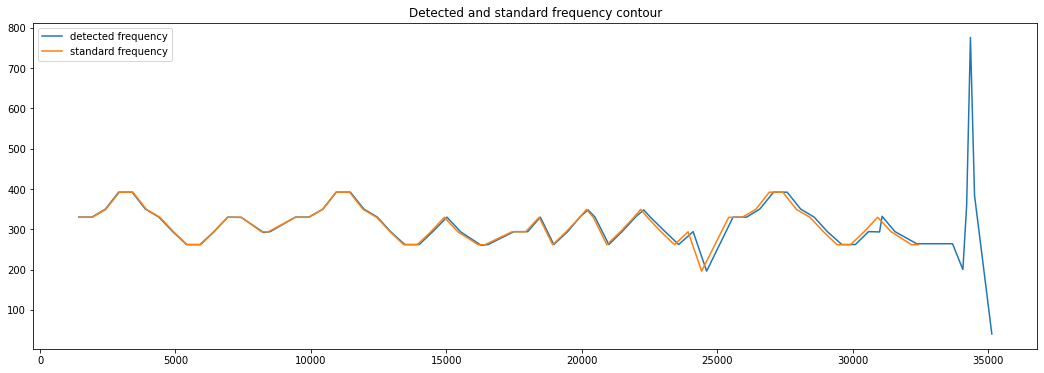

========== comparing ==========
E4:True | E4:True | F4:True | G4:True | G4:True | F4:True | E4:True | D4:True | C4:True | C4:True | D4:True | E4:True | E4:True | D4:True | D4:True | E4:True | E4:True | F4:True | G4:True | G4:True | F4:True | E4:True | D4:True | C4:True | C4:True | D4:True | E4:True | D4:True | C4:True | C4:True | D4:True | D4:True | E4:True | C4:True | D4:True | E4:True | F4:True | E4:True | C4:True | D4:True | E4:True | F4:True | E4:True | D4:WrongBeat | C4:WrongBeat | D4:WrongBeat | G3:WrongBeat | E4:WrongBeat | E4:WrongBeat | F4:True | G4:WrongBeat | G4:True | F4:WrongBeat | E4:WrongBeat | D4:True | C4:WrongBeat | C4:WrongBeat | D4:WrongBeat | E4:True | D4:True | C4:Miss | C4:Dup | 
correct_count: 48
freq_error 0
beat_error 13
========== generating overall report ==========
freq_score 100
beat_score 79
speed_score 98
correctness_score 77


In [239]:
file_name = '/Users/linyaya/Desktop/长版无错.m4a'
song_name = 'Ode To Joy'
start_time = 1222
bpm = 120
onset_i = 0
result, overall_report = process_music(file_name, start_time, bpm, song_name, onset_i)